
# Pre- vs Post-Training Embedding Analysis (Design Circuits)

This notebook reproduces the **t‑SNE + linear‑probe** analysis pattern on your graph embeddings, but **uses the pre‑trained and post‑trained models from your `design_circuits.py` pipeline**.
It loads each Stable-Baselines3 MaskablePPO policy, pulls out the **GAT-based feature extractor** defined in `design_circuits.py`, and compares the learned representations.

**What you get:**
- t‑SNE plots of graph embeddings (train/test) for **pre‑trained** and **post‑trained** models
- Linear‑probe accuracy (frozen features → logistic/linear classifier) to quantify separability
- Minimal configuration at the top for your paths & dataset size


In [1]:

# If needed, (un)comment and run once to install deps in your environment:
# !pip install -q torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu121
# !pip install -q torch-geometric==2.5.0
# !pip install -q stable-baselines3 sb3-contrib gymnasium matplotlib scikit-learn networkx

import os, sys, math, json, glob, importlib.util
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch import optim
import gymnasium as gym

from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score

from sb3_contrib import MaskablePPO


In [2]:

# ------------------- CONFIG -------------------
# Path to your design_circuits.py (the uploaded copy is used by default)
DESIGN_CIRCUITS_PATH = "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/design_circuits.py"  # ← change if needed

# Paths to SB3 policies (zip files) to compare:
# PRE_MODEL_PATH can be your "base / pre-trained" model (e.g., a model you fine-tuned from)
# POST_MODEL_PATH should be your trained or best model produced by design_circuits.py
# Examples (edit to your actual runs):
PRE_MODEL_PATH  = "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig2_single_circuits_0x99/seed_1/checkpoints/ppo_masked_16000_steps.zip"                 # e.g., args.fine_tuning you used
POST_MODEL_PATH = "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig3_4input_4000_logic_functions_registry_sampling_drl3env_loader5_v2/seed_1/trained_model.zip"      # or ".../best_model/best_model.zip"

# Base directory where your NIG pickles live:
DATA_BASE = "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data/NIGs_4_inputs"

# Truth-table hex IDs → class labels (adjust freely)
truth_tables = {
    "0x699D": 0,
    "0x70EC": 1,
    "0xBEE9": 2,
    "0x648B": 3,
    "0x6847": 4,
    "0x6572": 5,
    "0xDBFA": 6,
    "0x1D95": 7,
    "0x1FDE": 8,
    "0xD319": 9,
}
         
# Dataset parameters
per_table     = 100   # how many states/variants per truth table (if generator available; otherwise duplicates)
train_ratio   = 0.8
batch_size    = 32

# Model / observation-space parameters
max_nodes     = 100   # pad/crop to this many nodes
node_feat_dim = 4     # one-hot classes per node
device        = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cpu


In [3]:

# Dynamically import design_circuits.py so we can use its feature extractor & helpers.
assert os.path.exists(DESIGN_CIRCUITS_PATH), f"design_circuits.py not found at: {DESIGN_CIRCUITS_PATH}"

spec = importlib.util.spec_from_file_location("design_circuits", DESIGN_CIRCUITS_PATH)
dc = importlib.util.module_from_spec(spec)
sys.modules["design_circuits"] = dc
spec.loader.exec_module(dc)

# The features extractor class should be `GAT(BaseFeaturesExtractor)` in design_circuits.py
# It expects observation_space with keys: node_features, adj_matrix, scalars.
print("Imported from design_circuits.py:",
      [name for name in dir(dc) if name in ("GAT","load_graph_pickle")])


Importing modules
Done loading action motifs. There are 15928 unique motifs.
Number of CPU cores available: 64
CUDA available: False
Number of GPUs: 0
Finished with initial setup and going to main function
Imported from design_circuits.py: ['GAT', 'load_graph_pickle']


In [4]:

import scipy.sparse as sp

from dgd.utils.utils5 import resize_matrix, generate_one_hot_features_from_adj

'''
# ───────── t-SNE plotting helper ───────────────────────────────────
def plot_tsne(train_emb, test_emb, train_lbl, test_lbl, title_suffix=""):
    tsne = TSNE(n_components=2, perplexity=20, init="random", random_state=0)
    all_emb  = torch.cat([train_emb, test_emb], dim=0).cpu().numpy()
    xy       = tsne.fit_transform(all_emb)
    n_tr     = train_emb.size(0)

    fig, (ax_tr, ax_te) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True, tight_layout=True)

    def scat(ax, start, end, labels, title):
        sc = ax.scatter(xy[start:end, 0], xy[start:end, 1], c=labels, marker="o", s=40, linewidths=.5, edgecolors="k", alpha=.8)
        ax.set_title(title, fontsize=12);  ax.axis("off")

    scat(ax_tr, 0,        n_tr,  train_lbl.cpu().numpy(), "Train split")
    scat(ax_te, n_tr, None,      test_lbl.cpu().numpy(),  "Test split")    

    # Legend for classes 0..9
    h = [mpatches.Patch(label=f"class {i}") for i in range(10)]
    fig.legend(handles=h, loc="upper center", ncol=5, frameon=False)
    fig.suptitle(f"t-SNE of 128-dim graph embeddings {title_suffix}", y=1.02)
    plt.show()
'''
def plot_tsne(train_emb, test_emb, train_lbl, test_lbl, title_suffix=""):
    tsne = TSNE(n_components=2, perplexity=20, init="random", random_state=0)
    all_emb  = torch.cat([train_emb, test_emb], dim=0).numpy()
    xy       = tsne.fit_transform(all_emb)
    n_tr     = train_emb.size(0)

    cmap = plt.get_cmap("tab10", 10)
    fig, (ax_tr, ax_te) = plt.subplots(
        1, 2, figsize=(12, 6), sharex=True, sharey=True, tight_layout=True
    )

    def scat(ax, start, end, labels, title):
        ax.scatter(xy[start:end, 0], xy[start:end, 1],
                   c=labels, cmap=cmap, vmin=0, vmax=9,
                   marker="o", s=40, linewidths=.5,
                   edgecolors="k", alpha=.8)
        ax.set_title(title, fontsize=12);  ax.axis("off")

    scat(ax_tr, 0,        n_tr,  train_lbl.numpy(), "Train split")
    scat(ax_te, n_tr, None, test_lbl.numpy(),  "Test split")

    h = [mpatches.Patch(color=cmap(i), label=f"class {i}") for i in range(10)]
    fig.legend(handles=h, loc="upper center", ncol=5, frameon=False)
    fig.suptitle(f"t-SNE of 128-dim graph embeddings {title_suffix}", y=1.02)
    plt.show()

/home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/

In [5]:
import pickle

# Load graphs_library_4_input
with open('/home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/graphs_library_4_input_4_3_pruned.pkl', 'rb') as file:
    graphs_library_4_input = pickle.load(file)

# Load precomputed_graphs_4_input
with open('/home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/precomputed_graphs_4_input_4_3_pruned.pkl', 'rb') as file:
    precomputed_graphs_4_input = pickle.load(file)    
    
# Load graphs_library_3_input
with open('/home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/graphs_library_3_input_3_7_pruned.pkl', 'rb') as file:
    graphs_library_3_input = pickle.load(file)

# Load precomputed_graphs_3_input
with open('/home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/precomputed_graphs_3_input_3_7.pkl', 'rb') as file:
    precomputed_graphs_3_input = pickle.load(file)

# Load graphs_library_2_input
with open('/home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/graphs_library_2_input_pruned.pkl', 'rb') as file:
    graphs_library_2_input = pickle.load(file)

# Load precomputed_graphs_2_input
with open('/home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/precomputed_graphs_2_input.pkl', 'rb') as file:
    precomputed_graphs_2_input = pickle.load(file)
    
# Load graphs_library_1_input
with open('/home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/graphs_library_1_input_pruned.pkl', 'rb') as file:
    graphs_library_1_input = pickle.load(file)

# Load precomputed_graphs_1_input
with open('/home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/precomputed_graphs_1_input.pkl', 'rb') as file:
    precomputed_graphs_1_input = pickle.load(file)

In [6]:

class TruthTableDataset(Dataset):
    def __init__(self, truth_tables: dict[str, int], per_table: int, data_base: str, max_nodes: int):
        self.obs, self.labels = [], []
        for circuit_hex, lbl in truth_tables.items():
            path = os.path.join(data_base, f"{circuit_hex}_NIG_unoptimized.pkl")
            G0 = dc.load_graph_pickle(path)   # uses the helper defined in design_circuits.py

            # Try to import your random-state generator, else just duplicate base graph.
            from dgd.utils.utils5 import generate_random_initial_states_multi_input_v2
            states = generate_random_initial_states_multi_input_v2(
                G0, per_table,
                precomputed_graphs_1_input, graphs_library_1_input,
                precomputed_graphs_2_input, graphs_library_2_input,
                precomputed_graphs_3_input, graphs_library_3_input,
                precomputed_graphs_4_input, graphs_library_4_input
            )


            for G in states:
                # canonical topological node order for adjacency extraction
                nodelist   = list(nx.topological_sort(G)) if nx.is_directed_acyclic_graph(G) else list(G.nodes())
                adj_sparse = nx.adjacency_matrix(G, nodelist=nodelist)
                adj_dense  = adj_sparse.toarray().astype(np.float32)

                adj_matrix = resize_matrix(adj_dense, max_nodes)
                node_feat  = generate_one_hot_features_from_adj(adj_sparse, pad_size=max_nodes)
                scalars    = np.zeros(3, dtype=np.float32)

                self.obs.append({
                    "node_features": node_feat.astype(np.float32),
                    "adj_matrix"   : adj_matrix,
                    "scalars"      : scalars,
                })
                self.labels.append(lbl)

    def __len__(self):          return len(self.labels)
    def __getitem__(self, idx): return self.obs[idx], self.labels[idx]

# Build the full dataset (this may take a moment on first run)
full_ds = TruthTableDataset(truth_tables, per_table, DATA_BASE, max_nodes)
print(f"Total samples: {len(full_ds)}  |  per class: ~{per_table}")


Generating Random Initial States: 100%|██████████| 100/100 [00:03<00:00, 27.89state/s]


Total samples: 1010  |  per class: ~100


In [7]:

train_len = int(len(full_ds) * train_ratio)
test_len  = len(full_ds) - train_len
train_ds, test_ds = random_split(full_ds, [train_len, test_len], generator=torch.Generator().manual_seed(42))

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

observation_space = gym.spaces.Dict({
    "node_features": gym.spaces.Box(0,1,shape=(max_nodes, node_feat_dim), dtype=np.float32),
    "adj_matrix"   : gym.spaces.Box(0,1,shape=(max_nodes,max_nodes), dtype=np.float32),
    "scalars"      : gym.spaces.Box(0,1000,shape=(3,), dtype=np.float32),
})
print(observation_space)


Dict('adj_matrix': Box(0.0, 1.0, (100, 100), float32), 'node_features': Box(0.0, 1.0, (100, 4), float32), 'scalars': Box(0.0, 1000.0, (3,), float32))


In [8]:

assert os.path.exists(PRE_MODEL_PATH),  f"PRE_MODEL_PATH not found: {PRE_MODEL_PATH}"
assert os.path.exists(POST_MODEL_PATH), f"POST_MODEL_PATH not found: {POST_MODEL_PATH}"

pre_model  = MaskablePPO.load(PRE_MODEL_PATH,  device=device)





post_model = MaskablePPO.load(POST_MODEL_PATH, device=device)

# Extract GNN feature extractors (frozen eval mode)
pre_fe  = pre_model.policy.features_extractor.to(device).eval()
post_fe = post_model.policy.features_extractor.to(device).eval()

try:
    feature_dim = pre_model.policy.features_dim
except Exception:
    feature_dim = 128  # default from design_circuits.GAT
print("Feature dim:", feature_dim)


Feature dim: 128


In [9]:
import numpy as np
import torch
from torch.utils.data import DataLoader

def collate_obs(batch):
    """
    batch: list of (obs_dict, label)
    returns: (Dict[str, Tensor[B,...]], Tensor[B])
    """
    obs_list, labels = zip(*batch)  # lists of len B
    out = {}
    for k in obs_list[0].keys():
        vals = [np.asarray(sample[k], dtype=np.float32) for sample in obs_list]
        try:
            arr = np.stack(vals, axis=0)  # (B, ...)
        except Exception as e:
            shapes = [v.shape for v in vals]
            raise RuntimeError(f"Collate failed for key '{k}' with shapes {shapes}") from e
        out[k] = torch.from_numpy(arr)
    labels = torch.as_tensor(labels, dtype=torch.long)
    return out, labels

# Rebuild DataLoaders with the custom collate
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                      collate_fn=collate_obs, pin_memory=(device=='cuda'))
test_dl  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False,
                      collate_fn=collate_obs, pin_memory=(device=='cuda'))

# (Optional) sanity check one batch
obs_chk, y_chk = next(iter(train_dl))
print({k: (type(v), tuple(v.shape), v.dtype) for k, v in obs_chk.items()},
      "| labels:", y_chk.shape, y_chk.dtype)


{'node_features': (<class 'torch.Tensor'>, (32, 100, 4), torch.float32), 'adj_matrix': (<class 'torch.Tensor'>, (32, 100, 100), torch.float32), 'scalars': (<class 'torch.Tensor'>, (32, 3), torch.float32)} | labels: torch.Size([32]) torch.int64


In [10]:
@torch.no_grad()
def collect_embeddings_from_policy(policy, dataloader, device):
    fe = policy.features_extractor.to(device).eval()
    embs, lbls = [], []
    for obs, y in dataloader:
        obs = {k: v.to(device=device, dtype=torch.float32, non_blocking=True) for k, v in obs.items()}
        out = fe(obs)                # -> (B, feature_dim)
        if isinstance(out, (tuple, list)):
            out = out[0]
        embs.append(out.detach().cpu())
        lbls.append(y.clone().cpu())
    return torch.cat(embs, dim=0), torch.cat(lbls, dim=0)

# Use the SB3 models you loaded earlier
pre_train_emb,  pre_train_lbl  = collect_embeddings_from_policy(pre_model.policy,  train_dl, device)
pre_test_emb,   pre_test_lbl   = collect_embeddings_from_policy(pre_model.policy,  test_dl,  device)
post_train_emb, post_train_lbl = collect_embeddings_from_policy(post_model.policy, train_dl, device)
post_test_emb,  post_test_lbl  = collect_embeddings_from_policy(post_model.policy, test_dl,  device)

print("Embeddings collected:")
print(" pre  ->", pre_train_emb.shape, pre_test_emb.shape)
print(" post ->", post_train_emb.shape, post_test_emb.shape)


Embeddings collected:
 pre  -> torch.Size([808, 128]) torch.Size([202, 128])
 post -> torch.Size([808, 128]) torch.Size([202, 128])


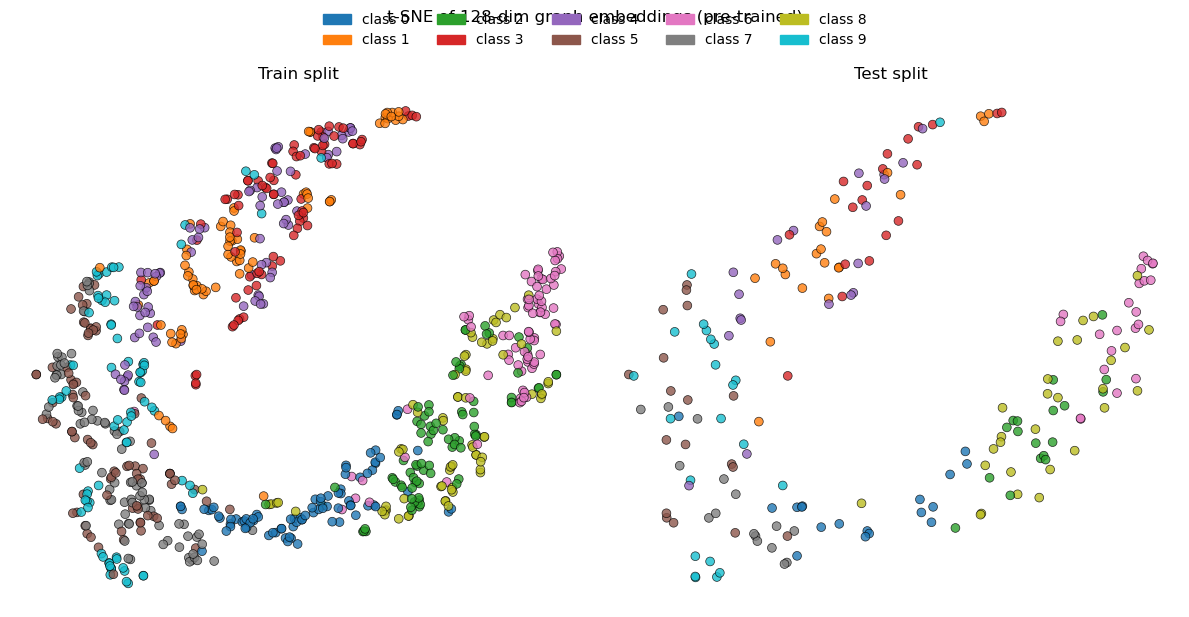

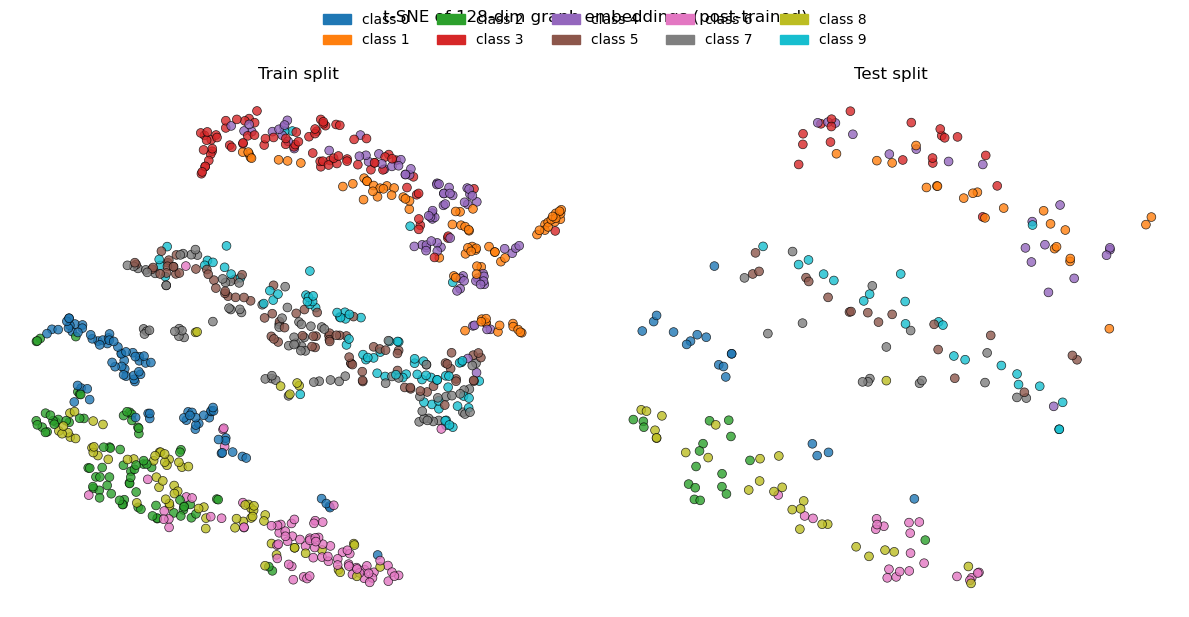

In [11]:

plot_tsne(pre_train_emb,  pre_test_emb,  pre_train_lbl,  pre_test_lbl,  title_suffix="(pre-trained)")
plot_tsne(post_train_emb, post_test_emb, post_train_lbl, post_test_lbl, title_suffix="(post-trained)")


In [12]:
class LinearProbe(nn.Module):
    def __init__(self, in_dim, n_classes):
        super().__init__()
        self.fc = nn.Linear(in_dim, n_classes)
    def forward(self, x): return self.fc(x)

def train_probe(train_x, train_y, test_x, test_y, n_classes, epochs=50, lr=1e-3):
    model = LinearProbe(train_x.shape[1], n_classes).to(device)
    opt   = optim.Adam(model.parameters(), lr=lr)
    lossf = nn.CrossEntropyLoss()
    train_x = train_x.to(device);  test_x = test_x.to(device)
    train_y = train_y.to(device);  test_y = test_y.to(device)

    for ep in range(epochs):
        model.train()
        opt.zero_grad()
        logits = model(train_x)
        loss = lossf(logits, train_y)
        loss.backward(); opt.step()

    model.eval()
    with torch.no_grad():
        tr_acc = (model(train_x).argmax(1) == train_y).float().mean().item()
        te_acc = (model(test_x ).argmax(1) == test_y ).float().mean().item()
    return tr_acc, te_acc

num_classes = len(truth_tables)
pre_tr_acc,  pre_te_acc  = train_probe(pre_train_emb,  pre_train_lbl,  pre_test_emb,  pre_test_lbl,  num_classes)
post_tr_acc, post_te_acc = train_probe(post_train_emb, post_train_lbl, post_test_emb, post_test_lbl, num_classes)

print(f"Pre-trained  probe accuracy: train={pre_tr_acc:.3f}  test={pre_te_acc:.3f}")
print(f"Post-trained probe accuracy: train={post_tr_acc:.3f} test={post_te_acc:.3f}")


Pre-trained  probe accuracy: train=0.265  test=0.203
Post-trained probe accuracy: train=0.313 test=0.332


In [13]:

summary = {
    "pre":  {"train_probe_acc": float(round(pre_tr_acc,  4)), "test_probe_acc": float(round(pre_te_acc,  4))},
    "post": {"train_probe_acc": float(round(post_tr_acc, 4)), "test_probe_acc": float(round(post_te_acc, 4))},
}
print(json.dumps(summary, indent=2))
with open("pre_post_embedding_summary.json", "w") as f:
    json.dump(summary, f, indent=2)
print("Wrote pre_post_embedding_summary.json")


{
  "pre": {
    "train_probe_acc": 0.2649,
    "test_probe_acc": 0.203
  },
  "post": {
    "train_probe_acc": 0.3131,
    "test_probe_acc": 0.3317
  }
}
Wrote pre_post_embedding_summary.json
